<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [2]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

!gdown --id 1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
# Распаковать архив в папку data/
!tar -xzvf handout.tar.gz

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=7fa757f6-6ba7-4a7c-b6c4-26ccdf675bc4
To: /content/handout.tar.gz
100% 884M/884M [00:14<00:00, 62.3MB/s]
data/
data/captions_tokenized.json
data/image_codes.npy


In [3]:
%%time
# Read Dataset
import numpy as np
import json


captions = json.load(open('data/captions_tokenized.json'))
img_codes = np.load("data/image_codes.npy")

CPU times: user 256 ms, sys: 2.44 s, total: 2.69 s
Wall time: 2.87 s



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_captions in captions:
    for caption in img_captions:
        for word in caption:
            word_counts[word] += 1

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [11]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0)))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [12]:
network = CaptionNet(n_tokens)

In [13]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [14]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(logits_for_next.view(-1, logits_for_next.size(-1)),captions_ix_next.view(-1), ignore_index=pad_ix, reduction='mean')
    return loss.unsqueeze(0)

In [15]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)
print('loss:', dummy_loss)
assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

loss: tensor([9.2717], grad_fn=<UnsqueezeBackward0>)



Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [16]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [17]:
from sklearn.model_selection import train_test_split

train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.1, random_state=42)

In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = [captions[i] for i in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [19]:
generate_batch(img_codes,captions,3)

(tensor([[0.6333, 0.4044, 0.3336,  ..., 0.4468, 1.2403, 0.6495],
         [0.8709, 0.4955, 0.8979,  ..., 0.2436, 0.4193, 0.0821],
         [0.3836, 0.1779, 0.3573,  ..., 0.1669, 0.5170, 0.4771]]),
 tensor([[   1, 1373,  588,   94,  557,   24,  640,  174,   24,   48,   55,   12,
             2],
         [   1,   88,  115,   46,  899,  576,   63,  417,   28, 9062,   12,    2,
             3],
         [   1,   29,   78,   24,   79,  174, 2855,   24, 3045,    2,    3,    3,
             3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [37]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch
n_stop = 10

In [38]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]



Epoch: 0, train loss: 3.398246967792511, val loss: 3.3708439826965333


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]



Epoch: 1, train loss: 3.378744354248047, val loss: 3.3670177459716797


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]



Epoch: 2, train loss: 3.288558464050293, val loss: 3.2897243976593016


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]



Epoch: 3, train loss: 3.2507313537597655, val loss: 3.175118827819824


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]



Epoch: 4, train loss: 3.194259479045868, val loss: 3.225399446487427


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]



Epoch: 5, train loss: 3.1524547576904296, val loss: 3.218573808670044


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]



Epoch: 6, train loss: 3.115969934463501, val loss: 3.162833261489868


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]



Epoch: 7, train loss: 3.0733106660842897, val loss: 3.1793673038482666


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]



Epoch: 8, train loss: 3.055551609992981, val loss: 3.098277473449707


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]



Epoch: 9, train loss: 3.0058637642860413, val loss: 3.064856004714966


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



Epoch: 10, train loss: 3.0105273818969724, val loss: 2.958715295791626


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]



Epoch: 11, train loss: 2.992387759685516, val loss: 2.9996170520782472


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]



Epoch: 12, train loss: 2.96405467748642, val loss: 3.045616292953491


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]



Epoch: 13, train loss: 2.94358952999115, val loss: 2.9621203422546385


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]



Epoch: 14, train loss: 2.917358014583588, val loss: 2.7710352420806883


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



Epoch: 15, train loss: 2.906433119773865, val loss: 2.938123369216919


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 16, train loss: 2.924648382663727, val loss: 2.9638282299041747


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]



Epoch: 17, train loss: 2.8499334979057314, val loss: 2.954889345169067


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]



Epoch: 18, train loss: 2.8798998737335206, val loss: 2.810400104522705


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Epoch: 19, train loss: 2.8370162224769593, val loss: 2.73944206237793


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



Epoch: 20, train loss: 2.823220062255859, val loss: 2.7953789234161377


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 21, train loss: 2.805559208393097, val loss: 2.8326820850372316


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]



Epoch: 22, train loss: 2.8004450273513792, val loss: 2.7297066688537597


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Epoch: 23, train loss: 2.8335230946540833, val loss: 2.7357604026794435


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]



Epoch: 24, train loss: 2.7727405285835265, val loss: 2.851419687271118


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]



Epoch: 25, train loss: 2.763337721824646, val loss: 2.7786544799804687


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 26, train loss: 2.77141747713089, val loss: 2.834145164489746


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 27, train loss: 2.7549393343925477, val loss: 2.6820786952972413


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Epoch: 28, train loss: 2.747144145965576, val loss: 2.725077819824219


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]



Epoch: 29, train loss: 2.747874402999878, val loss: 2.7833593845367433


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]



Epoch: 30, train loss: 2.736524534225464, val loss: 2.7909231662750242


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]



Epoch: 31, train loss: 2.6938601517677307, val loss: 2.8044004917144774


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Epoch: 32, train loss: 2.697026765346527, val loss: 2.82428092956543


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



Epoch: 33, train loss: 2.7067882680892943, val loss: 2.87433500289917


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 34, train loss: 2.6798232984542847, val loss: 2.8420703411102295


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]



Epoch: 35, train loss: 2.693934440612793, val loss: 2.8469433307647707


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]



Epoch: 36, train loss: 2.7103658270835878, val loss: 2.7174437999725343


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]



Epoch: 37, train loss: 2.673242971897125, val loss: 2.6648122310638427


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]



Epoch: 38, train loss: 2.682748782634735, val loss: 2.555246591567993


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 39, train loss: 2.6533394408226014, val loss: 2.61910080909729


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Epoch: 40, train loss: 2.6468388557434084, val loss: 2.7077050685882567


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Epoch: 41, train loss: 2.645983738899231, val loss: 2.726365327835083


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]



Epoch: 42, train loss: 2.6479146027565004, val loss: 2.6035178661346436


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Epoch: 43, train loss: 2.64570339679718, val loss: 2.7696921825408936


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]



Epoch: 44, train loss: 2.6418760085105895, val loss: 2.813468408584595


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]



Epoch: 45, train loss: 2.604701783657074, val loss: 2.7429350852966308


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]



Epoch: 46, train loss: 2.650742168426514, val loss: 2.7051395416259765


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



Epoch: 47, train loss: 2.621514754295349, val loss: 2.7091444969177245


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]



Epoch: 48, train loss: 2.624716341495514, val loss: 2.6707388401031493


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Epoch: 49, train loss: 2.6216015815734863, val loss: 2.6843722343444822


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 50, train loss: 2.601309857368469, val loss: 2.6527655601501463


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Epoch: 51, train loss: 2.5883221411705017, val loss: 2.5872231483459474


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]



Epoch: 52, train loss: 2.609234826564789, val loss: 2.66685152053833


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



Epoch: 53, train loss: 2.5813341665267946, val loss: 2.6765419006347657


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



Epoch: 54, train loss: 2.587973837852478, val loss: 2.5549543857574464


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]



Epoch: 55, train loss: 2.600011119842529, val loss: 2.544636917114258


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 56, train loss: 2.586828978061676, val loss: 2.6876641273498536


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



Epoch: 57, train loss: 2.594888231754303, val loss: 2.6866183280944824


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]



Epoch: 58, train loss: 2.5648357701301574, val loss: 2.69837646484375


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Epoch: 59, train loss: 2.5733223605155944, val loss: 2.638369846343994


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



Epoch: 60, train loss: 2.566655797958374, val loss: 2.6722360134124754


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]



Epoch: 61, train loss: 2.5909948325157166, val loss: 2.5908086776733397


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]



Epoch: 62, train loss: 2.5646709275245665, val loss: 2.603907823562622


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]



Epoch: 63, train loss: 2.542802712917328, val loss: 2.5195053577423097


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 64, train loss: 2.562833025455475, val loss: 2.5749505043029783


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]



Epoch: 65, train loss: 2.536508195400238, val loss: 2.577468681335449


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Epoch: 66, train loss: 2.5197983264923094, val loss: 2.602999210357666


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Epoch: 67, train loss: 2.5441668176651, val loss: 2.665323781967163


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]



Epoch: 68, train loss: 2.5403312397003175, val loss: 2.6028349876403807


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Epoch: 69, train loss: 2.547947599887848, val loss: 2.7035553455352783


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]



Epoch: 70, train loss: 2.550674021244049, val loss: 2.613101100921631


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Epoch: 71, train loss: 2.546141715049744, val loss: 2.6277207374572753


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Epoch: 72, train loss: 2.522511239051819, val loss: 2.6104092597961426


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]



Epoch: 73, train loss: 2.4893323254585265, val loss: 2.4855302810668944


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]



Epoch: 74, train loss: 2.518023343086243, val loss: 2.5728820323944093


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Epoch: 75, train loss: 2.528300077915192, val loss: 2.484859037399292


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]



Epoch: 76, train loss: 2.5210999608039857, val loss: 2.5776883602142333


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 77, train loss: 2.494182078838348, val loss: 2.5276819705963134


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]



Epoch: 78, train loss: 2.5218717455863953, val loss: 2.5766809463500975


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



Epoch: 79, train loss: 2.5077080726623535, val loss: 2.5942829608917237


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]



Epoch: 80, train loss: 2.490349676609039, val loss: 2.5297703742980957


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]



Epoch: 81, train loss: 2.506440360546112, val loss: 2.501283073425293


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Epoch: 82, train loss: 2.4797601008415224, val loss: 2.6031376838684084


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]



Epoch: 83, train loss: 2.4772581839561463, val loss: 2.6472785472869873


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]



Epoch: 84, train loss: 2.485795660018921, val loss: 2.6032008647918703


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Epoch: 85, train loss: 2.4785697293281554, val loss: 2.604952573776245


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Epoch: 86, train loss: 2.5140517354011536, val loss: 2.5552499771118162


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



Epoch: 87, train loss: 2.477952961921692, val loss: 2.575670099258423


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Epoch: 88, train loss: 2.4923742818832397, val loss: 2.596862030029297


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]



Epoch: 89, train loss: 2.493281652927399, val loss: 2.652594041824341


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]



Epoch: 90, train loss: 2.4624699568748474, val loss: 2.5554575443267824


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



Epoch: 91, train loss: 2.4430958104133604, val loss: 2.604706573486328


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]



Epoch: 92, train loss: 2.4815499067306517, val loss: 2.4074673652648926


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



Epoch: 93, train loss: 2.4532964277267455, val loss: 2.602283000946045


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]



Epoch: 94, train loss: 2.4472341918945313, val loss: 2.580154800415039


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]



Epoch: 95, train loss: 2.464671406745911, val loss: 2.436587190628052


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]



Epoch: 96, train loss: 2.485229058265686, val loss: 2.565729093551636


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



Epoch: 97, train loss: 2.469330394268036, val loss: 2.6015326499938967


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



Epoch: 98, train loss: 2.4779779386520384, val loss: 2.477379083633423


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]



Epoch: 99, train loss: 2.44963294506073, val loss: 2.431818056106567
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [39]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [40]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [68]:
from PIL import Image
import numpy as np

def imresize(img, size):
    return np.array(Image.fromarray(img).resize(size))


#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2025-10-30 16:59:18--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-30 16:59:19--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.02s   

2025-10-30 16:59:19 (3.28 MB/s) - ‘data/img.jpg’ saved [54731/547

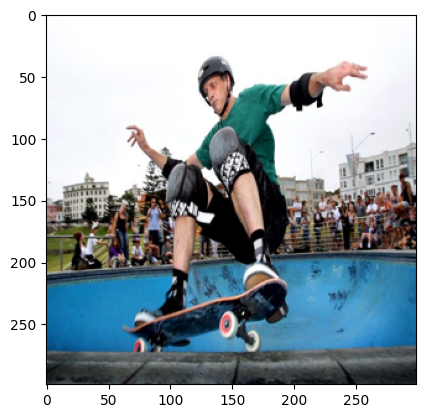

In [69]:
plt.imshow(img)

In [70]:
for i in range(10):
    print(' '.join(generate_caption(img, t=2)[1:-1]))

a man riding a skateboard on top of a ramp .
a skateboarder is in a skate park doing a trick
a man riding a skateboard up the side of a ramp .
a skateboarder performing a trick on a ramp .
a skateboarder doing a trick on a ramp .
a young man riding a skate board on a ramp .
a woman in a blue shirt is jumping off of a skateboard .
a skateboarder performing a trick on a skate board .
a skateboarder is jumping off a ramp on a skate board .
a man is riding a skateboard down a sidewalk .


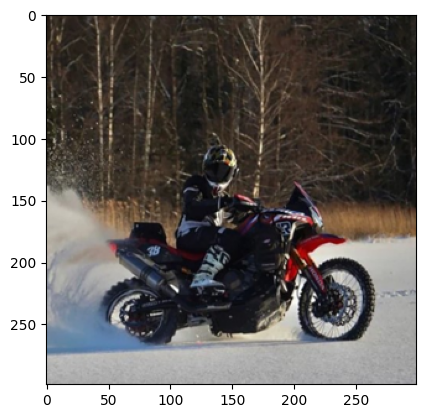

a motorcycle is parked in a field with trees in the background .
a motorcycle is parked in the dirt by a hill .
a motorcycle parked on the side of a road .
a motorcycle is parked in a field with a green background .
a motorcycle is parked in a dirt road .
a man riding a motorcycle in a field .
a motorcycle is parked on a dirt road .
a motorcycle that is parked in the grass .
a motorcycle is parked in a field with a mountain .
a motorcycle parked on the side of a dirt road .


In [108]:

img = plt.imread('demo_pics/203034.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

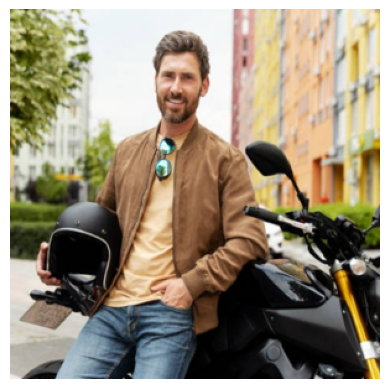

Вариант 1: a motorcycle parked on a street near a street .
Вариант 2: a man is standing next to a motorcycle .
Вариант 3: a motorcycle is parked in a parking lot .
Вариант 4: a man is sitting on a motorcycle in a parking lot .
Вариант 5: a man sitting on a motorcycle parked on a sidewalk .
Вариант 6: a man sitting on a motorcycle holding a dog .
--------------------------------------------------


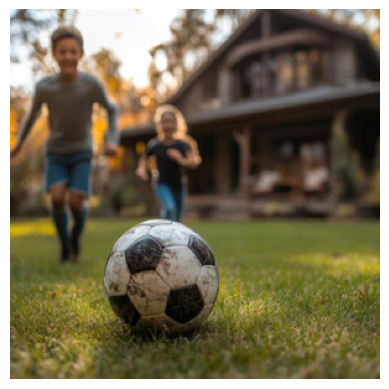

Вариант 1: a group of people standing on top of a field .
Вариант 2: a group of people standing around a field .
Вариант 3: a group of people standing in a field with a soccer ball .
Вариант 4: a group of people standing on top of a field .
Вариант 5: a group of men playing a game of soccer .
Вариант 6: a large group of people standing on top of a field .
--------------------------------------------------


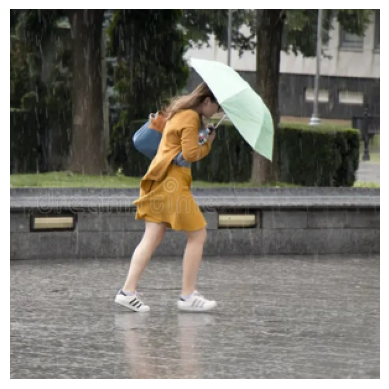

Вариант 1: a woman holding a pink umbrella on a street .
Вариант 2: a woman is holding a pink umbrella on a beach .
Вариант 3: a woman holding a pink umbrella at a beach
Вариант 4: a woman in a wet suit holding a umbrella .
Вариант 5: a woman in a pink dress and a blue umbrella
Вариант 6: a woman holding a umbrella in the rain .
--------------------------------------------------


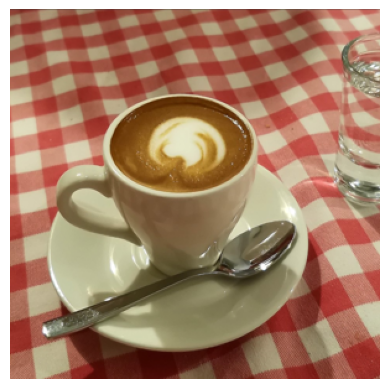

Вариант 1: a white plate topped with a cup of coffee and a cup of coffee .
Вариант 2: a plate of food with a sandwich and a cup of coffee .
Вариант 3: a plate with a sandwich and a cup of coffee .
Вариант 4: a plate of oranges and a cup of coffee .
Вариант 5: a coffee cup and a cup of coffee on a table .
Вариант 6: a plate of food that is on the table .
--------------------------------------------------


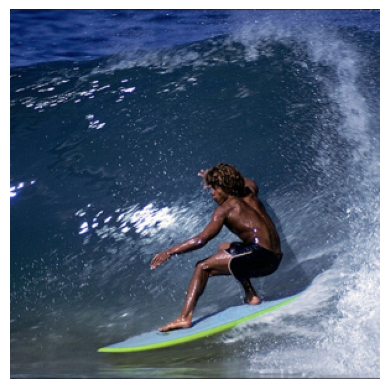

Вариант 1: a man that is on a surfboard in the ocean .
Вариант 2: a woman in a wet suit is surfing on a wave .
Вариант 3: a man on a surfboard in the ocean .
Вариант 4: a man riding a surfboard on top of a wave .
Вариант 5: a person on a surfboard in the ocean .
Вариант 6: a man on a surfboard in the ocean .
--------------------------------------------------


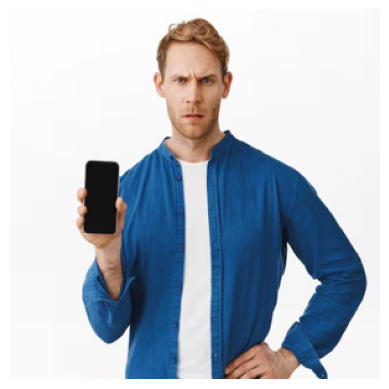

Вариант 1: a man holding a wii controller in his hand .
Вариант 2: a man holding a video game controller in a room .
Вариант 3: a man holding a nintendo wii controller in his hand .
Вариант 4: a man holding a wii controller in his hand .
Вариант 5: a man holding a large tie while standing next to a woman .
Вариант 6: a man holding a video game controller in his hand .
--------------------------------------------------


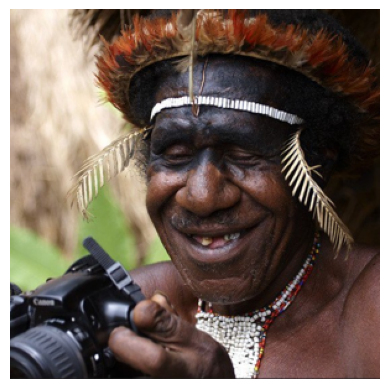

Вариант 1: a woman holding a cell phone in his hand .
Вариант 2: a man with a hat in his mouth while talking on a cell phone .
Вариант 3: a woman wearing a hat and tie with a baseball bat .
Вариант 4: a man in a hat holds a cell phone .
Вариант 5: a man is holding a cell phone in his hand .
Вариант 6: a man with a hat in his mouth talking on his phone
--------------------------------------------------


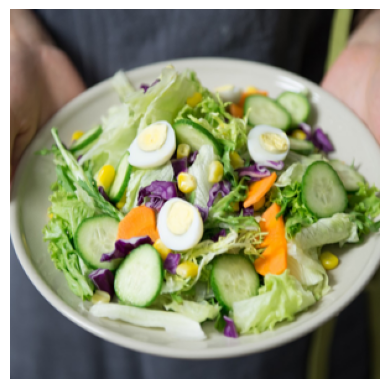

Вариант 1: a plate of food with a bowl of broccoli and a fork on a plate .
Вариант 2: a bowl of vegetables and an apple in a bowl .
Вариант 3: a plate of food with meat , broccoli , and a bowl of soup .
Вариант 4: a plate of food with broccoli , bread , and meat .
Вариант 5: a plate of food with a fork and a spoon .
Вариант 6: a plate of food with a meat and a knife in it .
--------------------------------------------------


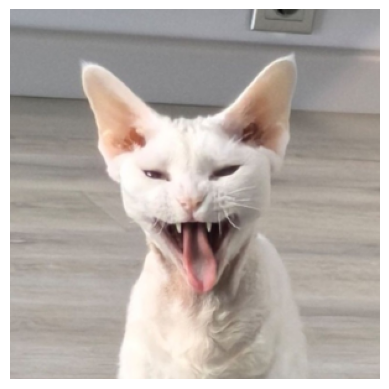

Вариант 1: a cat is sitting on a wooden table .
Вариант 2: a cat is standing on a wooden floor .
Вариант 3: a cat is sitting on a wooden table .
Вариант 4: a cat sitting on a wooden floor .
Вариант 5: a cat sitting on top of a wooden table .
Вариант 6: a cat is sitting on a wooden floor .
--------------------------------------------------


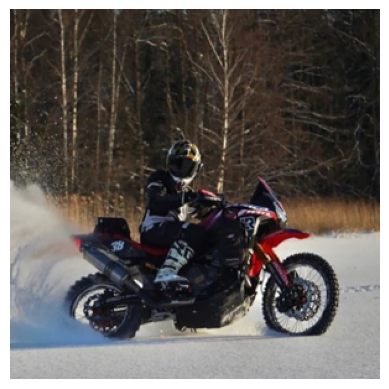

Вариант 1: a motorcycle is parked on the side of the road .
Вариант 2: a motorcycle is parked in a field with a mountain in the background .
Вариант 3: a motorcycle is parked in the grass near a road .
Вариант 4: a motorcycle parked on the side of a road .
Вариант 5: a motorcycle is parked on the side of a road .
Вариант 6: a motorcycle is parked in the dirt and grass .
--------------------------------------------------


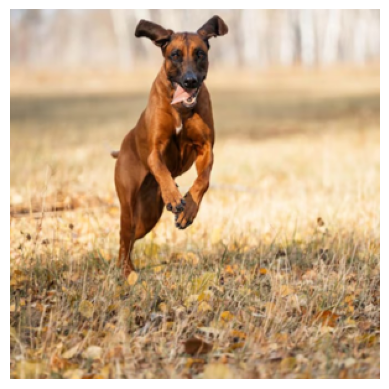

Вариант 1: a dog that is on a brown horse .
Вариант 2: a dog running on a dirt road in a field .
Вариант 3: a dog is standing in the grass with a dog in the background .
Вариант 4: a dog laying on a lush green field .
Вариант 5: a dog on a field with a frisbee in it's mouth .
Вариант 6: a dog is on a brown horse in the field
--------------------------------------------------


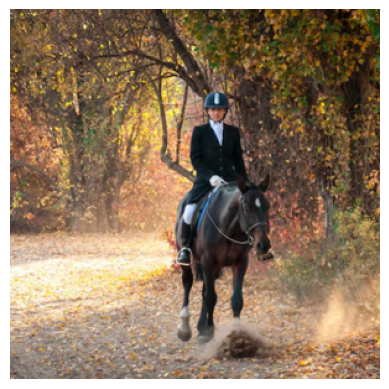

Вариант 1: a man riding a horse in a field .
Вариант 2: a horse on a dirt road with a man in the background .
Вариант 3: a person riding a horse in a field .
Вариант 4: a man riding a horse in a field .
Вариант 5: a man is riding a horse in a field .
Вариант 6: a man riding on a horse in a dirt field .
--------------------------------------------------


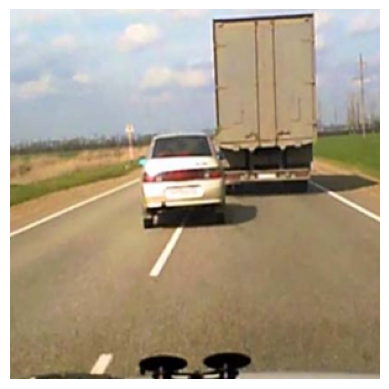

Вариант 1: a pair of motorcycles parked on the side of a road .
Вариант 2: a car parked on a rail road with a car
Вариант 3: a motorcycle parked on the side of a road
Вариант 4: a white motorcycle parked in a parking lot .
Вариант 5: a car parked next to a parking meter .
Вариант 6: a large truck parked on the side of a road .
--------------------------------------------------


In [110]:
# apply your network on images you've found
#
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

import os

def imresize(img, size):
    return np.array(Image.fromarray(img).resize(size))

# Получаем все картинки из папки demo_pics
image_dir = "demo_pics"
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"Файл {img_path} не найден.")
        continue
    img = plt.imread(img_path)
    img = imresize(img, (299, 299)).astype('float32') / 255.
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    for i in range(6):
        caption = ' '.join(generate_caption(img, t=2.5)[1:-1])
        print(f"Вариант {i+1}: {caption}")
    print('-'*50)



![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
